In [1]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt

from gptopt.linalg_utils import ns_pinv, ns_pinv_v2, rel_err, power_method


In [2]:
A = torch.load("/mnt/home/nghosh/GPT-opt/debug_matrices/C_transformer.h.11.mlp.c_proj.weight_step_52.pt")
G = torch.load("/mnt/home/nghosh/GPT-opt/debug_matrices/grad_transformer.h.11.mlp.c_proj.weight_step_52.pt")

# A = torch.load("/mnt/home/nghosh/GPT-opt/debug_matrices/C_transformer.h.0.attn.c_attn.weight_step_1.pt")
# G = torch.load("/mnt/home/nghosh/GPT-opt/debug_matrices/grad_transformer.h.0.attn.c_attn.weight_step_1.pt")

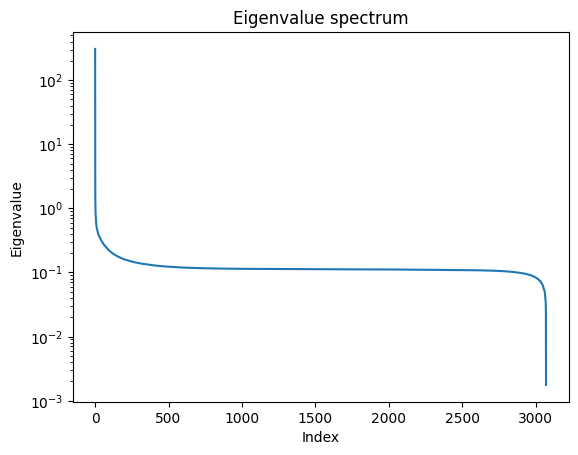

In [3]:
# Compute eigenvalues and sort in descending order
eigvals, eigvecs = torch.linalg.eigh(A)
# Sort in descending order and get sorting indices
sort_idx = torch.argsort(eigvals, descending=True)
# Sort both eigenvalues and eigenvectors
eigvals = eigvals[sort_idx]
eigvecs = eigvecs[:, sort_idx]

plt.figure()
plt.plot(eigvals.cpu())
plt.title("Eigenvalue spectrum")
plt.xlabel("Index")
plt.ylabel("Eigenvalue") 
plt.yscale("log")
plt.show()


eps=4.8125


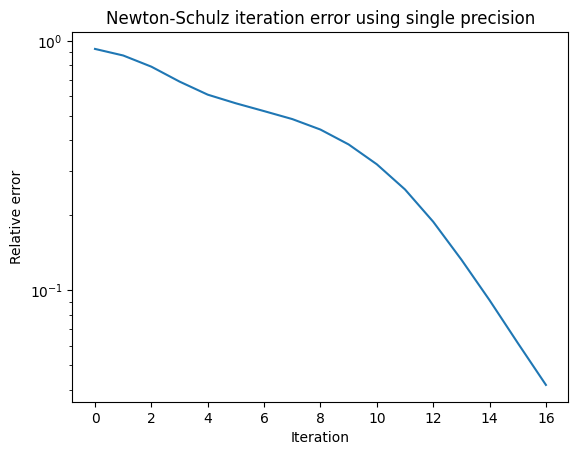

In [41]:
use_bf16 = True

eps = power_method(A, psd=True, use_bf16=use_bf16) * 1e-1
print(f"eps={eps}")

A_pinv, diagnostics = ns_pinv_v2(A, eps=eps, max_steps=100, use_bf16=use_bf16, diagnostics=True)
plt.plot([res['AXA'] for res in diagnostics['residuals']])
plt.title("Newton-Schulz iteration error using single precision")
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.yscale("log")
plt.show()

In [43]:
rel_err(G @ A_pinv.float() @ A, G)

0.23321379721164703